This notebook will begin the analysis of at-risk students


In [6]:
import pandas as pd

# Load Didactic Grades (All Sheets)
didactic_path = r"C:\Users\chris\Documents\PA_Data_Analysis\PA-Student-Performance-Analysis\data\Didactic_Grades_Cohort_20-23.xlsx" 
didactic_sheets = pd.read_excel(didactic_path, sheet_name=None)  # Load all sheets

# Load PANCE Scores
pance_path = r"C:\Users\chris\Documents\PA_Data_Analysis\PA-Student-Performance-Analysis\data\PANCE_Scores_Cohort_2020-2022.xlsx"
pance_df = pd.read_excel(pance_path, sheet_name=None)  # Load all sheets

# Load course catalog excel file
course_catalog_path = r"C:\Users\chris\Documents\PA_Data_Analysis\PA-Student-Performance-Analysis\data\Course_Catalog.xlsx"
course_catalog_df = pd.read_excel(course_catalog_path, sheet_name="Course_Catalog") 

# Check available sheets in Didactic file
print("Didactic Sheets:", list(didactic_sheets.keys()))

# Preview first sheet
first_sheet_name = list(didactic_sheets.keys())[0]
print(first_sheet_name)
didactic1_df = didactic_sheets[first_sheet_name]  # Load first sheet as example
print(didactic1_df.head())

Didactic Sheets: ['Dataset COH 2020', 'Cohort of 2020 (C22)', 'Dataset COH2021', 'Cohort of 2021 (C23)', 'Dataset COH2022', 'Cohort of 2022 (C24)', 'Dataset COH2023', 'Cohort of 2023 (C25)']
Dataset COH 2020
  Unique Masked ID Course Code                          Course Name   Grade
0       COH2020-01     PAS 612                Clinical Medicine III   96.17
1       COH2020-01     PAS 622                         PA Practicum  100.00
2       COH2020-01     PAS 632             Pharmacotherapeutics III   95.12
3       COH2020-01     PAS 642                  Pathophysiology III   93.53
4       COH2020-01     PAS 660  Diagnostic & Therapeutic Procedures   91.08


In [3]:
def flag_at_risk(df, cohort_year):
    student_avg = df.groupby("Unique Masked ID")["Grade"].mean().reset_index()
    student_avg = student_avg.rename(columns={"Grade": "Avg Grade"})
    student_avg["Cohort Year"] = cohort_year

    mean = student_avg["Avg Grade"].mean()
    std = student_avg["Avg Grade"].std()

    def get_flag(grade):
        if grade < (mean - std):  
            return "At Risk"
        elif grade < 80:                         
            return "Borderline"
        else:
            return "Safe" 

    # This line must assign back
    student_avg["Risk Category"] = student_avg["Avg Grade"].apply(get_flag)

    return student_avg

cohort_2020_flags = flag_at_risk(didactic1_df, "2020")

# Calculate mean and std for cohort 2020
mean = cohort_2020_flags["Avg Grade"].mean()

std = cohort_2020_flags["Avg Grade"].std()
at_risk_cutoff = mean - std

print(f"Cohort 2020 — Mean: {mean:.2f}, Std Dev: {std:.2f}, At-Risk Cutoff: {at_risk_cutoff:.2f}")

print(cohort_2020_flags["Risk Category"].value_counts())


print(cohort_2020_flags.head(30))



Cohort 2020 — Mean: 95.48, Std Dev: 1.68, At-Risk Cutoff: 93.80
Risk Category
Safe       26
At Risk     4
Name: count, dtype: int64
   Unique Masked ID  Avg Grade Cohort Year Risk Category
0        COH2020-01  96.347778        2020          Safe
1        COH2020-02  96.312778        2020          Safe
2        COH2020-03  91.074444        2020       At Risk
3        COH2020-04  98.145000        2020          Safe
4        COH2020-05  93.620000        2020       At Risk
5        COH2020-06  96.482222        2020          Safe
6        COH2020-07  96.373889        2020          Safe
7        COH2020-08  96.432222        2020          Safe
8        COH2020-09  96.047778        2020          Safe
9        COH2020-10  94.120000        2020          Safe
10       COH2020-11  96.210000        2020          Safe
11       COH2020-12  98.308889        2020          Safe
12       COH2020-13  94.627778        2020          Safe
13       COH2020-14  94.906667        2020          Safe
14       COH2

We need to do a weighted average because the pass/fail classes are heavily affecting the grades.

In [7]:
didactic1_df_merged = didactic1_df.merge(course_catalog_df, on="Course Code", how="left")

# Check if the merge was successful
print(didactic1_df_merged.head())

  Unique Masked ID Course Code                          Course Name   Grade  \
0       COH2020-01     PAS 612                Clinical Medicine III   96.17   
1       COH2020-01     PAS 622                         PA Practicum  100.00   
2       COH2020-01     PAS 632             Pharmacotherapeutics III   95.12   
3       COH2020-01     PAS 642                  Pathophysiology III   93.53   
4       COH2020-01     PAS 660  Diagnostic & Therapeutic Procedures   91.08   

  Semester                                         Class Name  Credit Hours  \
0   Summer     Clinical Medicine for Physician Assistants III           6.0   
1   Summer                      Physician Assistant Practicum           3.0   
2   Summer  Pharmacotherapeutics for Physician Assistants III           3.0   
3   Summer       Pathophysiology for Physician Assistants III           3.0   
4   Summer    Patient Assessment for Physician Assistants III           3.0   

  Pass/Fail  
0     False  
1     False  
2     Fa

In [8]:
def calculate_weighted_avg(df):
    # Ignore Pass/Fail by setting Credit Hours to 0
    df = df.copy()
    df.loc[df["Pass/Fail"] == True, "Credit Hours"] = 0

    # Calculate Weighted Grade
    df["Weighted Grade"] = df["Grade"] * df["Credit Hours"]

    # Compute Weighted Avg per Student
    weighted_avg = df.groupby("Unique Masked ID").agg({
        "Weighted Grade": "sum",
        "Credit Hours": "sum"
    }).reset_index()

    weighted_avg["Avg Grade"] = weighted_avg["Weighted Grade"] / weighted_avg["Credit Hours"]
    return weighted_avg


In [9]:
def flag_at_risk_weighted(df):
    weighted_avg = calculate_weighted_avg(df)
    #weighted_avg["Cohort Year"] = cohort_year

    def categorize(grade):
        if grade < 85:
            return "At Risk"
        elif grade < 90:
            return "Borderline"
        else:
            return "Safe"

    weighted_avg["Risk Category"] = weighted_avg["Avg Grade"].apply(categorize)
    return weighted_avg


In [10]:
cohort_2020_flags = flag_at_risk_weighted(didactic1_df_merged)

print(cohort_2020_flags[["Unique Masked ID", "Avg Grade", "Risk Category"]])



   Unique Masked ID  Avg Grade Risk Category
0        COH2020-01  95.620182          Safe
1        COH2020-02  95.582909          Safe
2        COH2020-03  86.571273    Borderline
3        COH2020-04  98.034182          Safe
4        COH2020-05  92.485636          Safe
5        COH2020-06  95.842727          Safe
6        COH2020-07  95.675818          Safe
7        COH2020-08  95.878000          Safe
8        COH2020-09  95.264909          Safe
9        COH2020-10  92.919455          Safe
10       COH2020-11  95.305273          Safe
11       COH2020-12  98.107455          Safe
12       COH2020-13  93.473091          Safe
13       COH2020-14  94.119091          Safe
14       COH2020-15  94.968364          Safe
15       COH2020-16  96.046364          Safe
16       COH2020-17  95.054364          Safe
17       COH2020-18  93.305818          Safe
18       COH2020-19  96.003636          Safe
19       COH2020-20  92.583818          Safe
20       COH2020-21  94.466000          Safe
21       C

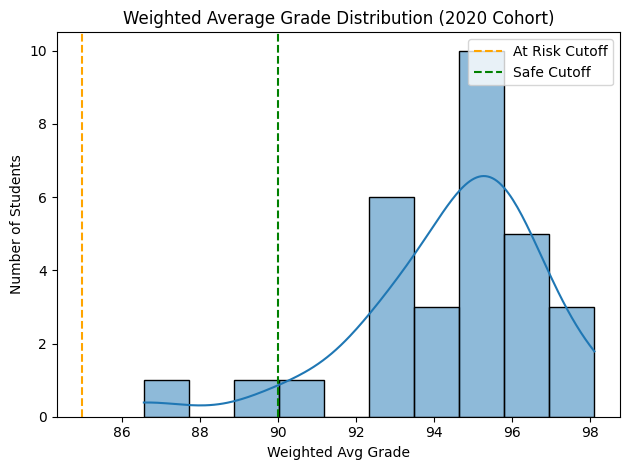

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(cohort_2020_flags["Avg Grade"], bins=10, kde=True)
plt.title("Weighted Average Grade Distribution (2020 Cohort)")
plt.xlabel("Weighted Avg Grade")
plt.ylabel("Number of Students")
plt.axvline(85, color="orange", linestyle="--", label="At Risk Cutoff")
plt.axvline(90, color="green", linestyle="--", label="Safe Cutoff")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print("Min:", cohort_2020_flags["Avg Grade"].min())
print("Max:", cohort_2020_flags["Avg Grade"].max())
print("Mean:", cohort_2020_flags["Avg Grade"].mean())
print("Std Dev:", cohort_2020_flags["Avg Grade"].std())
